In [1]:
# ABOUT THE CODE
# This code recives two input files: one for the points of the roads and one for the cities.
# Returns a network Gc with the distances between cities.


# ABOUT THE FORMAT OF THE INPUT FILES:
# .SHP file:
#   - No null values
#   - The coordinates should be tagged as 'coordinates'
#     Otherwise you have to modify line 36,44 (Block 1) and 30 (Block 2): replace 'coordinates' for 'NEWNAME' (commas included)
#   * Notice that those number lines may not be correct if there is some new line in the code, just look for the coorect line.
#
# The city names of the .DBF file should: 
#   - Be short
#   - Not contain any comma or strange character
#   - Be tagged as 'TITLE'. Otherwise you have to modify line 31, block 2: replace 'TITLE' for 'NEWNAME' (commas included)
#   - Not be null
#   - The identification (and maybe others) number, if exists, can't be too large.
#
# ABOUT THE CSV FOR GEPHI:
#   - Edges table files require, at minimum, columns labeled 'Source' and 'Target' (which can be case insensitive)
# - Edge type is optional and its default is 'Directed' 

# ABOUT THE RADIUS FILE:
# In case you have a file containing the radius of each town, its format must be: town_i ; radius_i ;\n
#
# ALL THE FILES NEEDED MUST BE IN THE SAME FOLDER AS THIS PROGRAM

In [4]:
import networkx as nx
import matplotlib
import shapefile
from pyproj import Proj, transform # Needed to change coordinates
from network_functions import *
from dbfread import DBF  # Needed to read .dbf files which contains town attributes
import time

In [5]:
# ***************************************************************************************************************
#                               BLOCK (1): ROADS
# ***************************************************************************************************************

print(' BLOCK 1: ROADS')

# CREATING A FILE WITH THE PATH POINTS COORDINATES
#input_name="BA_roads.shp"
print("Roads: Input file name (i.e.: name.shp ) (It can't contain space or special characters.")
#input_name=input()
shape = shapefile.Reader(input())

#input_coordinates='epsg:4326'
print("Coordinates (i.e.: epsg:4326 )")
#input_coordinates=input()

inProj = Proj(init=input())
outProj = Proj(init='epsg:4326')


ncamins=len(shape.shapes()) # Number of paths (a path can contain several segments)"
npunts=0 # Number of points
maxpunts=0 # Number of points that the largest path has got
nedge=0  # Number of edges
correcte=0
error=0

n=-1
with open("camins.txt","w") as fitxer:
    for nn in range(0,ncamins):
        feature=shape.shapeRecords()[nn]
        try:
            first=feature.shape.__geo_interface__
            punts_cami=0
            if first["type"]== "LineString":   # For paths containing just 1 segment
                segment=first["coordinates"]
                n=n+1
                for punt in segment: 
                    fitxer.write(str(n)+";"+str(punt)+"\n")
                    npunts=npunts+1
                    punts_cami=punts_cami+1

            elif first["type"]== "MultiLineString": # For paths made with more than 1 segment
                cami=first["coordinates"]
                for segment in cami:
                    n=n+1
                    for punt in segment:
                        fitxer.write(str(n)+";"+str(punt)+"\n")
                        npunts=npunts+1
                        punts_cami=punts_cami+1

            if maxpunts<punts_cami:   
                maxpunts=punts_cami
            correcte=correcte+1
        except:
            print('There is some error related to the input roads file format.')
            print(feature.record)
            error=error+1
            n=n+1
            
print('Information about the road points: ')
with open('camins.txt','r') as fitxer:
    sumatori=0
    a=0
    total_npoints=0
    npoints=0
    dmax=0
    dmin=0
    a2=0
    
    for linia in fitxer:    
        if a>0:
            linia=linia.split(";")
            posicions=linia[1].split(",")
            xold=x
            yold=y
            x=posicions[0]
            y=posicions[1]
            x=x.replace('(','') 
            y=y.replace(')','')      
            x,y = transform(inProj, outProj, x,y) # Les coordenades han d'estar en graus

            new_n = linia[0]
            total_npoints=total_npoints+1
            if new_n== old_n:     
                r= coord_geodist(float(yold), float(xold), float(y),float(x)) # Distancia entre dos punts consecutius
                npoints=npoints+1
                sumatori=sumatori+1
                if r>dmax:
                    dmax=r
                if a2==0:
                    dmin=r
                    a2=1
                if a2>0:
                    if r < dmin and r!=0:
                        dmin=r     
            else:
                old_n=new_n

        else: 
            linia=linia.split(";")
            old_n=linia[0]
            posicions=linia[1].split(",")
            x=posicions[0]
            y=posicions[1]
            x=x.replace('(','') 
            y=y.replace(')','')   
            x,y = transform(inProj, outProj, x,y) # Coordinates must be in degrees
            a=1
            total_npoints=total_npoints+1
        
print('Average distance between two consecutive points: ', sumatori/npoints)
print('Minimum distance between two consecutive points: ', dmin)
print('Maximum distance between two consecutive points: ', dmax)
print('Number of points: ', total_npoints)
    

# CREATING THE PATH POINTS NETWORK
print('rmax: maximum distance between to consecutive points of different Multiline(in km). (i.e.: 0.01)')
print('Introduce a value for rmax: ')
rmax=float(input())

G=nx.Graph()   
with open("camins.txt","r") as fitxer:
    nnode=0
    a=0
    for linia in fitxer:    
        if a>0:
            linia=linia.split(";")
            posicions=linia[1].split(",")
            xold=x
            yold=y
            x=posicions[0]
            y=posicions[1]
            x=x.replace('(','') 
            y=y.replace(')','')      
            x,y = transform(inProj, outProj, x,y) # Les coordenades han d'estar en graus

            nnode=nnode+1
            G.add_node(str(nnode), pos=(float(x),float(y)),longitude=float(x),latitude=float(y), is_city=False, radius=0)
            r= coord_geodist(float(yold), float(xold), float(y),float(x)) # Distancia entre dos punts consecutius
            new_n = linia[0]
            
        # Requirement to create an edge 
            if new_n== old_n:     
                G.add_edge(str(nnode-1), str(nnode))
                nedge=nedge+1
            else: 
                if r<rmax:
                    G.add_edge(str(nnode-1), str(nnode))
                    nedge=nedge+1
                old_n=new_n
           
        else: 
            linia=linia.split(";")
            old_n=linia[0]
            posicions=linia[1].split(",")
            x=posicions[0]
            y=posicions[1]
            x=x.replace('(','') 
            y=y.replace(')','')   
            x,y = transform(inProj, outProj, x,y) # Coordinates must be in degrees
            nnode=nnode+1
            G.add_node(str(nnode), pos=(float(x),float(y)),longitude=float(x),latitude=float(y),is_city=False, radius=0)
            a=1
print('Number of edges', nedge)


# MERGING NODES WHICH ARE CLOSER THAN Dth
print('Dth: maximum distance between two nodes that will be merged, in km. (i.e. 1)' )
print('Insert a value for Dth:')
Dth=float(input())

t3=time.time()
if Dth>0:
    D=dist_matrix(G, eucl=False)   
    a=list(G.nodes())


    merge_list=[]
    for i,n1 in enumerate(G.nodes()):
        for j,n2 in enumerate(G.nodes()):
            if (D[i][j]<Dth) and (i != j):
                merge_list.append([n1,n2,D[i][j]])

    for m in merge_list:
        n1=m[0]
        n2=m[1]
        if n1 in G.nodes():
            if n2 in G.nodes():
                G=nx.contracted_nodes(G,n1,n2,self_loops=False)
                        
t4=time.time()            

print(' Block 1: done')

 BLOCK 1: ROADS
Roads: Input file name (i.e.: name.shp ) (It can't contain space or special characters.
BA_roads.shp


ShapefileException: Unable to open BA_roads.dbf or BA_roads.shp.

Drawing of the roads


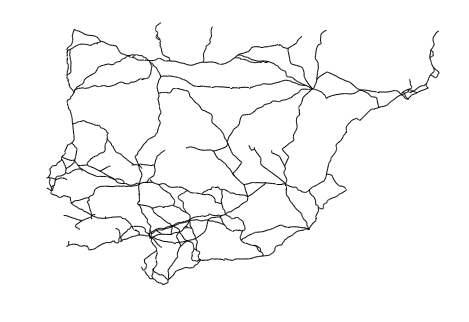

In [5]:
print('Drawing of the roads')
nx.draw(G, nx.get_node_attributes(G,'pos'), with_labels=False, node_size=0)
# If it doesn't show any drawing, please execute this box again. 

In [6]:
# ***************************************************************************************************************
#                               BLOCK (2): TOWNS NETWORK 
# ***************************************************************************************************************

print('BLOCK 2: TOWNS NETWORK')

# CREATING A FILE WITH THE COORDINATES OF EACH TOWN
#city_input_name="towns_Iberian2.shp"    
print("Towns: Input file name (i.e.: name.shp ) (It can't contain space or special characters.")
shape = shapefile.Reader(input())

print("Coordinates (i.e.: epsg:32630 )")
#city_input_coordinates='epsg:32630'

inProj = Proj(init=str(input()))  
outProj = Proj(init='epsg:4326')


nmax=len(shape.shapes())
print("Number of towns: ", nmax)
fitxer2 = DBF('towns_Iberian2.dbf',encoding='utf-8')
with open("ciutats.txt","w") as fitxer:
    n=0
    error=0
    correcte=0
    for linia2 in fitxer2:      
        feature=shape.shapeRecords()[n]
        try:
            first=feature.shape.__geo_interface__
            linia=str(first["coordinates"])
            nom=str(linia2['TITLE'])
            fitxer.write(linia+";"+nom+"\n")
            n=n+1
            correcte=correcte+1
        except:
            error=error+1
            n=n+1
print(correcte,'correct towns out of ', error+correcte)


# RADIUS OF THE TOWNS 
print('If you want to create a file with the radius of the towns, insert 1. If you already have one, insert 2. Otherwise 3. ')
condicio=int(input())
radis=[]
if condicio==1:
    print('File name: ')
    nom=input()
    with open(nom,'w') as f:
        c=list(H.nodes())
        for i in range(0,len(c)):
            print('City: ', c[i], 'Radius: ')
            valor=float(input())
            f.write(c[i]+';'+str(valor)+';\n')
            radis.append[valor]
    
if condicio==2:
    print('Name of the file: ')
    nom_radi=input()
    radis=[]
    with open(nom_radi,'r') as nr:
        for linia in nr:
            linia=linia.split(";")     # If you have another separator change ";" for you separator: "separator"
            radis.append(float(linia[1]))
            
# CREATING THE TOWNS NETWORK
H=nx.Graph()
with open("ciutats.txt","r") as fitxer:
    nnode=0
    a=0
    index=0
    for linia in fitxer:
        if a>0:
            linia=linia.split(";")
            nom=linia[1]
            nom=nom.replace('\n','')
            posicions=linia[0].split(",")
            x=posicions[0]
            y=posicions[1]
            x=x.replace('(','') 
            y=y.replace(')','')  
            x,y = transform(inProj, outProj, x,y) # The coordinates must be in degrees
            nnode=nnode+1
            if condicio!=3:
                radi=radis[index]
                H.add_node(str(nom), 
pos=(float(x),float(y)),longitude=float(x),latitude=float(y),is_city=True, radius=radi)
                index=index+1
            if condicio==3:
                H.add_node(str(nom), 
pos=(float(x),float(y)),longitude=float(x),latitude=float(y),is_city=True)
                        
        else: 
            linia=linia.split(";")
            nom=linia[1]
            nom=nom.replace('\n','')
            posicions=linia[0].split(",")
            x=posicions[0]
            y=posicions[1]
            x=x.replace('(','') 
            y=y.replace(')','') 
            x,y = transform(inProj, outProj, x,y) # The coordinates must be in degrees
            nnode=nnode+1
            if condicio!=3:
                radi=radis[index]
                H.add_node(str(nom), 
pos=(float(x),float(y)),longitude=float(x),latitude=float(y),is_city=True, radius=radi)
                index=index+1
            if condicio==3:
                H.add_node(str(nom), 
pos=(float(x),float(y)),longitude=float(x),latitude=float(y),is_city=True)
                
            a=1
print('Block 2: done')

BLOCK 2: TOWNS NETWORK
Towns: Input file name (i.e.: name.shp ) (It can't contain space or special characters.
towns_Iberian2.shp
Coordinates (i.e.: epsg:32630 )
epsg:32630
Number of towns:  342
287 correct towns out of  342
If you want to create a file with the radius of the towns, insert 1. If you already have one, insert 2. Otherwise 3. 
3
2: done


BLOCK 3: NETWORK OF TOWNS+ ROADS
Radius of the cities. If you have a csv file containing the radius, insert 1. If not, insert 2.
2
Insert a value for a fixed value of the city radius:
5
Two cities will be merged:  Castro Ventosa  and  Bergidum Flavium
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  Caum  and  Las Coronas
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  Tróia  and  Caetobriga
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  Torre de los Moros  and  Keresos
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  *Cortona  and  Okilis
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  Allobo  and  Cabañas de Ebro
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  Atxa  and  Kutzemendi
If you want to merge it insert 1. If not, 2.
2
Two cities will be merged:  Atxa  and  Suessatium
If you want to merge it insert 1. If not, 2.
2
Tw

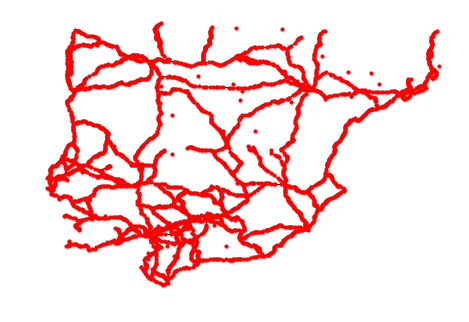

In [7]:
# ***************************************************************************************************************
#                               BLOCK (3): NETWORK OF TOWNS+ ROADS 
# ***************************************************************************************************************

print('BLOCK 3: NETWORK OF TOWNS+ ROADS')

U=nx.union(G,H,rename=(None, None),name=None)


#### MERGING THE NODES OF THE TOWNS WITH THE NODES OF THE ROADS WHICH ARE CLOSER THAN Dth
print('Radius of the cities. If you have a csv file containing the radius, insert 1. If not, insert 2.')
radius_option=int(input())
if radius_option==1: 
    towns=list(H.nodes(data=True))
    points=list(U.nodes(data=True))
    for town in range(0,len(H)):
        for point in range(0,len(U)):
            p1=towns[town][1]
            p2=points[point][1]

            if (towns[town][0]!=points[point][0]) and (points[point][0] in U.nodes()):
                d = point_geodist(p1, p2)
                Dth2=radis[town]
                if d < Dth2:
                    if points[point][1]['is_city']==False:
                        U=nx.contracted_nodes(U,towns[town][0],points[point][0],self_loops=False)
                    else:
                        print('Two cities will be merged: ',towns[town][0],' and ',points[point][0])
                        print('If you want to merge it insert 1. If not, 2.')
                        continuar=int(input())
                        if continuar==1:
                            U=nx.contracted_nodes(U,towns[town][0],points[point][0],self_loops=False)
            
if radius_option==2: 
    towns=list(H.nodes(data=True))
    points=list(U.nodes(data=True))  
    print('Insert a value for a fixed value of the city radius:')
    Dth2=float(input())
    for town in range(0,len(H)):
    #for town in range(0,3):
        for point in range(0,len(U)):
            p1=towns[town][1]
            p2=points[point][1]
            if (towns[town][0]!=points[point][0]) and (points[point][0] in U.nodes()):
                d = point_geodist(p1, p2)
                if d < Dth2:
                    if points[point][1]['is_city']==False:
                        U=nx.contracted_nodes(U,towns[town][0],points[point][0],self_loops=False)
                    else:
                        print('Two cities will be merged: ',towns[town][0],' and ',points[point][0])
                        print('If you want to merge it insert 1. If not, 2.')
                        continuar=int(input())
                        if continuar==1:
                            U=nx.contracted_nodes(U,towns[town][0],points[point][0],self_loops=False)
                            
# CREATING A LIST OF THE ISOLATED TOWNS

isolated=[]
for node in list(U.nodes(data=True)):
    
    if(node[1]['is_city'])==True:
        if nx.is_isolate(U, node[0])==True:
            isolated.append(node[0])
print('Isolated cities: ', isolated, 'Dth2 =',Dth2,'km.')
print('Number of isolates: ', len(isolated))
#nx.draw(U, nx.get_node_attributes(U,'pos'), with_labels=False, node_size=3)


# MODIFICATION OF THE ISOLATED LIST
a=U.node(data=True)
near=[]
print('Do you want to include some isolated cities with a new fixed value of Dth? In that case, insert: 1 ')
print('If you want to do it one city by one, insert: 2 ')
print("If you don't want to modify those isolated cities, insert: 3 ")
fixed=int(input())
if fixed==1:
    print('Value for Dth2: ')
    Dth2=float(input())
    print('1.Minimum distances between isolated nodes and its nearests points :')
    for node1 in isolated:
        x1=a[node1]['pos'][0]
        y1=a[node1]['pos'][1]
        w=0
        for node2 in a:
            x2=node2[1]['pos'][0]
            y2=node2[1]['pos'][1]
            distancia=coord_geodist(float(y2), float(x2), float(y1),float(x1))
            if w==0 and node1!=node2[0]:
                min_dist=[distancia,node2[0]]
                w=1
            else:
                if node1 !=node2[0]:
                    if distancia < min_dist[0]:
                        if node2[1]['is_city']==False:
                            min_dist=[distancia,node2[0]]
        print('Isolated node:', node1, 'Nearest point: ',min_dist[1], 'Distance: ',min_dist[0])
        if min_dist[0]< Dth2:
            U=nx.contracted_nodes(U,node1,min_dist[1],self_loops=False)
            
            print('llista min dist', min_dist)
if fixed==2: 
    print('2.Minimum distances between isolated nodes and its nearests points :')
    print('Insert True in case you want to include this town and False otherwise.')
    for node1 in isolated:
        x1=a[node1]['pos'][0]
        y1=a[node1]['pos'][1]
        w=0
        for node2 in a:
            x2=node2[1]['pos'][0]
            y2=node2[1]['pos'][1]
            distancia=coord_geodist(float(y2), float(x2), float(y1),float(x1))
            if w==0 and node1!=node2[0]:
                min_dist=[distancia,node2[0]]
                w=1
            else:
                if node1 !=node2[0]:
                    if distancia < min_dist[0]:
                        if node2[1]['is_city']==False:
                            min_dist=[distancia,node2[0]]
        print('Isolated node:', node1, 'Nearest point: ',min_dist[1], 'Distance: ',min_dist[0])
        Dth2=bool(input())
        if Dth2==True:
            U=nx.contracted_nodes(U,node1,min_dist[1],self_loops=False)
if fixed==3:
    print('No changes in isolated cities: ', isolated)

if fixed!=3:
    isolated2=[]
    for node in list(U.node(data=True)):
        if U.degree(node[0])==0:
            isolated2.append(node[0])
    print('Isolated cities: ', isolated2, 'Dth2 =',Dth2,'km. Number of isolates: ', len(isolated2))
    
nx.draw(U, nx.get_node_attributes(U,'pos'), with_labels=False, node_size=10)
print(' Block 3: done')

Drawing of the network of roads+towns: 


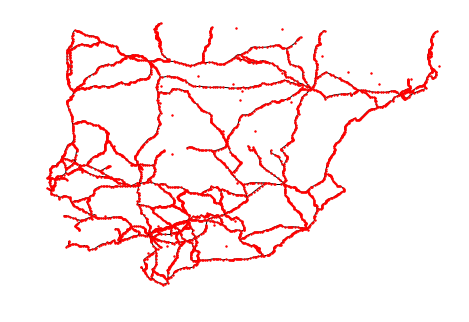

In [8]:
print('Drawing of the network of roads+towns: ')
nx.draw(U, nx.get_node_attributes(U,'pos'), with_labels=False, node_size=2)
# If it doesn't show any drawing, please execute this box again. 

In [9]:
# ***************************************************************************************************************
#                               BLOCK (4): NETWORK OF DISTANCES
# ***************************************************************************************************************

print(' BLOCK (4): NETWORK OF DISTANCES')
print('p parameter: if the length of a direct path is p times larger than the direct path, the direct path replaces the shortest.')
print('Introduce a value for p: ')
p=float(input())
t1=time.time()

ciutats=[]
for c in U.nodes('is_city'):
    if c[1]==True : 
        ciutats.append(c[0])

A=[]
ciutats0=[]
ciutats0.append(0)
for c in ciutats:
    ciutats0.append(c)
A.append(ciutats0)
alfa=len(ciutats0)
for city in ciutats:
    llista=[]
    llista.append(city)
    for i in range(0, len(ciutats)):
        llista.append(0)
    A.append(llista)
B=A.copy()
            
# CREATING A NETWORK WITHOUT INTERMEDIATE TOWNS

for i in range(1,alfa):
    for j in range(1,alfa):
        haspath=nx.has_path(U, str(B[0][j]), str(B[i][0]))
        if j!=i and haspath==True:
            Ucopy=U.copy()
            crem=ciutats.copy()
            crem.remove(str(B[0][j]))
            crem.remove(str(B[i][0]))
            for cr in crem:
                Ucopy.remove_node(cr)
            haspath2=nx.has_path(Ucopy, str(B[0][j]), str(B[i][0]))

            if haspath2==True:                     
                shpath=nx.shortest_path(Ucopy, source=str(B[0][j]), target=str(B[i][0]), weight=None)
                sh_len=length_path(Ucopy, shpath)
                B[i][j]=sh_len
            else:
                B[i][j]=-1

        else:               
            B[i][j]=-1
            
            
# SHORTESTS PATHS (only when already exists a direct path)
            
for i in range(1,alfa):
    for j in range(1,alfa):
        if j!=i and B[i][j]>0:
            shpath=nx.shortest_path(U, source=str(A[0][j]), target=str(A[i][0]), weight=None)
            sh_len=length_path(U, shpath)
            A[i][j]=sh_len
        else:               
            A[i][j]=-1
            
# CREATING THE FINAL NETWORK Gc

Gc=nx.Graph()
Gc.add_nodes_from(H.nodes(data=True))
llistaGc=list(Gc.nodes(data=True))
for i in range(1,alfa):
    for j in range(1,alfa):
        if B[i][j]>0:
            if A[i][j]>0:
                if B[i][j]>p*A[i][j]:  
                    Gc.add_edge(str(B[0][j]),str(B[i][0]), weight=A[i][j])
                else:
                    Gc.add_edge(str(B[0][j]),str(B[i][0]), weight=B[i][j])
            else:
                Gc.add_edge(str(B[0][j]),str(B[i][0]), weight=B[i][j])

t2=time.time()
print(' Block 4: done')

 BLOCK (4): NETWORK OF DISTANCES
P parameter: if length of a direct path is p < times larger than the direct path, the direct path replaces the shortest.
Introduce a value for p: 
2
4: done


Drawing of the final Gc network of direct path: 


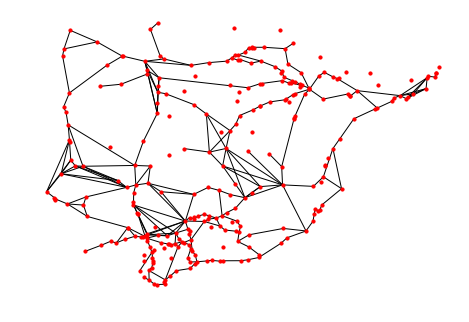

In [10]:
print('Drawing of the final Gc network of direct path: ')
nx.draw(Gc, nx.get_node_attributes(Gc,'pos'), with_labels=False, node_size=10)
# If it doesn't show any drawing, please execute this box again. 

In [12]:
print('BLOCK 5: EXPORTING THE FINAL NETWORK' )

# ***************************************************************************************************************
#                               BLOCK (5): EXPORTING THE FINAL NETWORK 
# ***************************************************************************************************************

#name_file_output1='def_Dth1_1_Dth_5_Gc.gdf'
print('gdf file name for the final Gv network: ')
name_file_output1=input()
if condicio!=3:
    nxgraph_to_gdf(Gc,name_file_output1, node_attr=["longitude","latitude","is_city","radius"], edge_attr=None, giant=False)
if condicio==3:
    nxgraph_to_gdf(Gc,name_file_output1, node_attr=["longitude","latitude","is_city"], edge_attr=None, giant=False)

#name_file_output1='def_Dth1_1_Dth_5_edge.gdf'
print('gdf file name for the roads network U: ')
name_file_output2=input()

if condicio!=3:
    nxgraph_to_gdf(U,name_file_output2, node_attr=["longitude","latitude","is_city","radius"], edge_attr="Weight", giant=False)
if condicio==3:
    nxgraph_to_gdf(U,name_file_output2, node_attr=["longitude","latitude","is_city"], edge_attr=None, giant=False)

print('5: done')

BLOCK 5: EXPORTING THE FINAL NETWORK
gdf file name for the final Gv network: 
Gc_network.gdf
node attr 0 : double
node attr 1 : double
node attr 2 : varchar
writing...
nodes header done
nodes done
edges header done
edges done
gdf file name for the roads network U: 
U_network.gdf
node attr 0 : double
node attr 1 : double
node attr 2 : varchar
writing...
nodes header done
nodes done
edges header done
edges done
5: done


In [13]:
print('Approximate time needed ', (t2-t1+t4-t3)/60, 'minutes')

Approximate time needed  36.57608656088511 minutes


In [14]:
print('gdf file name for the roads network U: ')
name_file_output2=input()

if condicio!=3:
    nxgraph_to_gdf(G,name_file_output2, node_attr=["longitude","latitude","is_city","radius"], edge_attr="Weight", giant=False)
if condicio==3:
    nxgraph_to_gdf(G,name_file_output2, node_attr=["longitude","latitude","is_city"], edge_attr=None, giant=False)

gdf file name for the roads network U: 
G_network.gdf
node attr 0 : double
node attr 1 : double
node attr 2 : varchar
writing...
nodes header done
nodes done
edges header done
edges done
